In [1]:
import pickle

In [2]:
with open('../../cm_train_contrastive_tupels.pkl', 'rb') as f:
    list_moral_tupels = pickle.load(f)

In [ ]:
list_moral_tupels

In [4]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from data.mft_dim import moral_foundations, generate_mc_prompts

In [5]:
dataset = generate_mc_prompts(moral_foundations, instruct_model=True)

In [ ]:
dataset

In [7]:
from transformer_lens import HookedTransformer
import transformer_lens.utils as utils

In [ ]:
model = HookedTransformer.from_pretrained("google/gemma-2-9b-it")

In [ ]:
entry = 22
print(dataset[entry]["correct_answer"])
utils.test_prompt(dataset[entry]["prompt"], " A", model)


In [ ]:
print(model.to_str_tokens( " A, B,A,B"))
tokens = model.to_tokens(" A, B,A,B")
print(tokens)
model.to_string(tokens)

In [11]:
logits = model.run_with_cache(dataset[entry]["prompt"], return_type="logits")



In [ ]:
print(logits[0][0,-1,586])
print(logits[0][0,-1,599])


In [ ]:
import torch
print(torch.argmax(logits[0][0,-1,:]))
prob = torch.softmax(logits[0][0,-1,:], dim=-1)
print(prob)
print(prob[586])
print(prob[599])


In [ ]:
correct_predictions = 0
total = len(dataset)

for idx, entry in enumerate(dataset):
    # Get logits for the prompt
    logits = model.run_with_cache(entry["prompt"], return_type="logits")
    
    # Get probabilities for the last position
    probs = torch.softmax(logits[0][0,-1,:], dim=-1)
    
    # Get token IDs for " A" and " B"
    token_A = 586  # Usually will be around 586
    token_B = 599  # Usually will be around 599
    
    # Get the model's prediction (A or B based on higher probability)
    pred = "A" if probs[token_A] > probs[token_B] else "B"
    
    # Compare with correct answer
    is_correct = pred == entry["correct_answer"]
    correct_predictions += int(is_correct)
    
    print(f"Entry {idx}: Predicted {pred}, Correct {entry['correct_answer']}, "
          f"Prob A: {probs[token_A]:.3f}, Prob B: {probs[token_B]:.3f}, "
          f"{'✓' if is_correct else '✗'}")

accuracy = correct_predictions / total
print(f"\nOverall accuracy: {accuracy:.2%}")

In [ ]:
from data.mft_dim import get_moral_statements
moral_statements = get_moral_statements(dimension="care", moral=True)
moral_statements

In [ ]:
utils.test_prompt(moral_statements[0]["prompt"], "agree", model)

In [ ]:
model.to_tokens("agree")

In [19]:
prompt = "Do you agree or disagree with the following Statement: One should never come to the aid of a stranger in distress. Moral dimension: care. Do agree or disagree? (max 15 words) "

In [ ]:
model.eval()  # Ensure the model is in evaluation mode

# Generate tokens
num_tokens_to_generate = 60
generated_text = model.generate(prompt, max_new_tokens=num_tokens_to_generate)

# Print the generated text
print(generated_text)

In [ ]:
prompt

In [ ]:
# Initialize lists to store probabilities
agree_probs = []
disagree_probs = []
generated_tokens = []

# Get initial tokens
tokens = model.to_tokens(prompt)
initial_len = tokens.shape[1]

# Generate one token at a time and get probabilities
for i in range(num_tokens_to_generate):
    # Get logits for next token
    logits = model(tokens)[:,-1]
    probs = torch.softmax(logits, dim=-1)
    
    # Get probabilities for agree/disagree tokens
    agree_token = model.to_tokens(" agree")[0,1]  
    disagree_token = model.to_tokens(" disagree")[0,1]
    
    agree_prob = probs[0,agree_token].item()
    disagree_prob = probs[0,disagree_token].item()
    
    agree_probs.append(agree_prob)
    disagree_probs.append(disagree_prob)
    
    # Sample next token
    next_token = torch.multinomial(probs[0], num_samples=1)
    tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)
    
    # Store generated token
    generated_tokens.append(model.to_string(next_token.unsqueeze(0)))
    
    # Break if EOS token generated
    if next_token.item() == model.tokenizer.eos_token_id:
        break

# Print probabilities and tokens at each step
for i, (token, agree_p, disagree_p) in enumerate(zip(generated_tokens, agree_probs, disagree_probs)):
    print(f"Position {i+initial_len} ({token}): Agree prob: {agree_p:.3f}, Disagree prob: {disagree_p:.3f}")


In [ ]:

# Calculate total probabilities
total_agree = sum(agree_probs)
total_disagree = sum(disagree_probs)
mean_agree = total_agree / len(agree_probs)
mean_disagree = total_disagree / len(disagree_probs)
highest_agree = max(agree_probs)
highest_disagree = max(disagree_probs)

print(f"\nMean probability for Agree: {mean_agree:.3f}")
print(f"Mean probability for Disagree: {mean_disagree:.3f}")

print(f"Highest probability for Agree: {highest_agree:.3f}")
print(f"Highest probability for Disagree: {highest_disagree:.3f}")

print(f"Total probability for Agree: {total_agree:.3f}")
print(f"Total probability for Disagree: {total_disagree:.3f}")




### Moral Analyzer whole sequence

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from data.mft_dim import moral_foundations, generate_mc_prompts, get_moral_statements
from src.analysis.moral_analyzer import MoralBehaviorAnalyzer
from transformer_lens import HookedTransformer

In [3]:
model = HookedTransformer.from_pretrained("google/gemma-2-9b-it")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/root/miniconda/envs/mech/lib/python3.10/site-packages/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


Loaded pretrained model google/gemma-2-9b-it into HookedTransformer


In [4]:
analyzer = MoralBehaviorAnalyzer(model)

Initialized collector with 42 layers and 14336 neurons per layer


In [5]:
# Data list of moral statements and immoral statements
moral_statements = get_moral_statements(dimension="care", moral=True)
immoral_statements = get_moral_statements(dimension="care", moral=False)

moral_pairs = [(statement["statement"], immoral_statements[i]["statement"]) for i, statement in enumerate(moral_statements)]

moral_pairs[0]

('One should always come to the aid of a stranger in distress.',
 'It’s acceptable to ignore a stranger’s suffering if it doesn’t affect you.')

In [6]:
moral_pairs[1]

('Providing shelter and food to the homeless is our fundamental duty.',
 'Homelessness is their own problem; society has no obligation to intervene.')

In [7]:
results = analyzer.analyze_moral_behavior(
    moral_pairs,
    temporal_window=5
)

Analyzing moral pairs:   0%|          | 0/40 [00:00<?, ?it/s]


Activation difference statistics:
Maximum difference: 8.338975
Mean absolute difference: 0.009727

Difference distribution percentiles:
0th percentile: -7.118932
25th percentile: -0.004773
50th percentile: -0.000000
75th percentile: 0.004781
100th percentile: 8.338975

Moral Neuron (7, 5276):
Mean difference: 0.051523
Consistency: 0.568750
Most consistent positions: [(21, 0.02500000037252903), (22, 0.02500000037252903), (23, 0.02500000037252903)]
Sample-wise means: [0.02389552816748619, 0.033546533435583115, 0.0588454008102417, 0.16101223230361938, 0.05865509435534477, -0.007121124770492315, -0.00661954190582037, 0.09425737708806992, 0.07970041036605835, 0.10805483162403107, 0.034351248294115067, 0.022489648312330246, 0.0333225317299366, 0.03236495703458786, 0.07613638043403625, 0.02205326221883297, 0.051412470638751984, 0.0761854276061058, 0.013503878377377987, 0.07105416059494019, 0.0644320547580719, 0.07323893904685974, 0.0546630322933197, 0.025546859949827194, 0.019196806475520134

In [8]:
results

{'moral_neurons': [(7, 5276),
  (8, 755),
  (11, 2295),
  (12, 1164),
  (12, 1984),
  (13, 13425),
  (14, 303),
  (14, 1718),
  (14, 2047),
  (14, 10231),
  (16, 4420),
  (16, 6638),
  (17, 10981),
  (17, 11326),
  (18, 154),
  (18, 883),
  (18, 3404),
  (19, 82),
  (19, 8658),
  (20, 9329),
  (20, 9583),
  (21, 7100),
  (22, 9482),
  (23, 86),
  (23, 128),
  (23, 4010),
  (23, 5963),
  (23, 7297),
  (23, 10673),
  (24, 476),
  (24, 2804),
  (24, 3425),
  (24, 13565),
  (25, 1203),
  (25, 9649),
  (26, 6625),
  (28, 8428),
  (28, 10813),
  (28, 12443),
  (29, 1553),
  (29, 12749),
  (31, 7661),
  (35, 9342),
  (38, 11109),
  (38, 11996),
  (39, 5546),
  (39, 13163),
  (40, 9343),
  (41, 11298)],
 'immoral_neurons': [],
 'temporal_patterns': {},
 'key_trigger_points': [(3, 0.014094514772295952),
  (11, 0.014090463519096375),
  (6, 0.01401849277317524),
  (2, 0.013995783403515816),
  (9, 0.013825805857777596)],
 'key_trigger_contexts': [{'position': 0,
   'token': '<bos>',
   'context': 

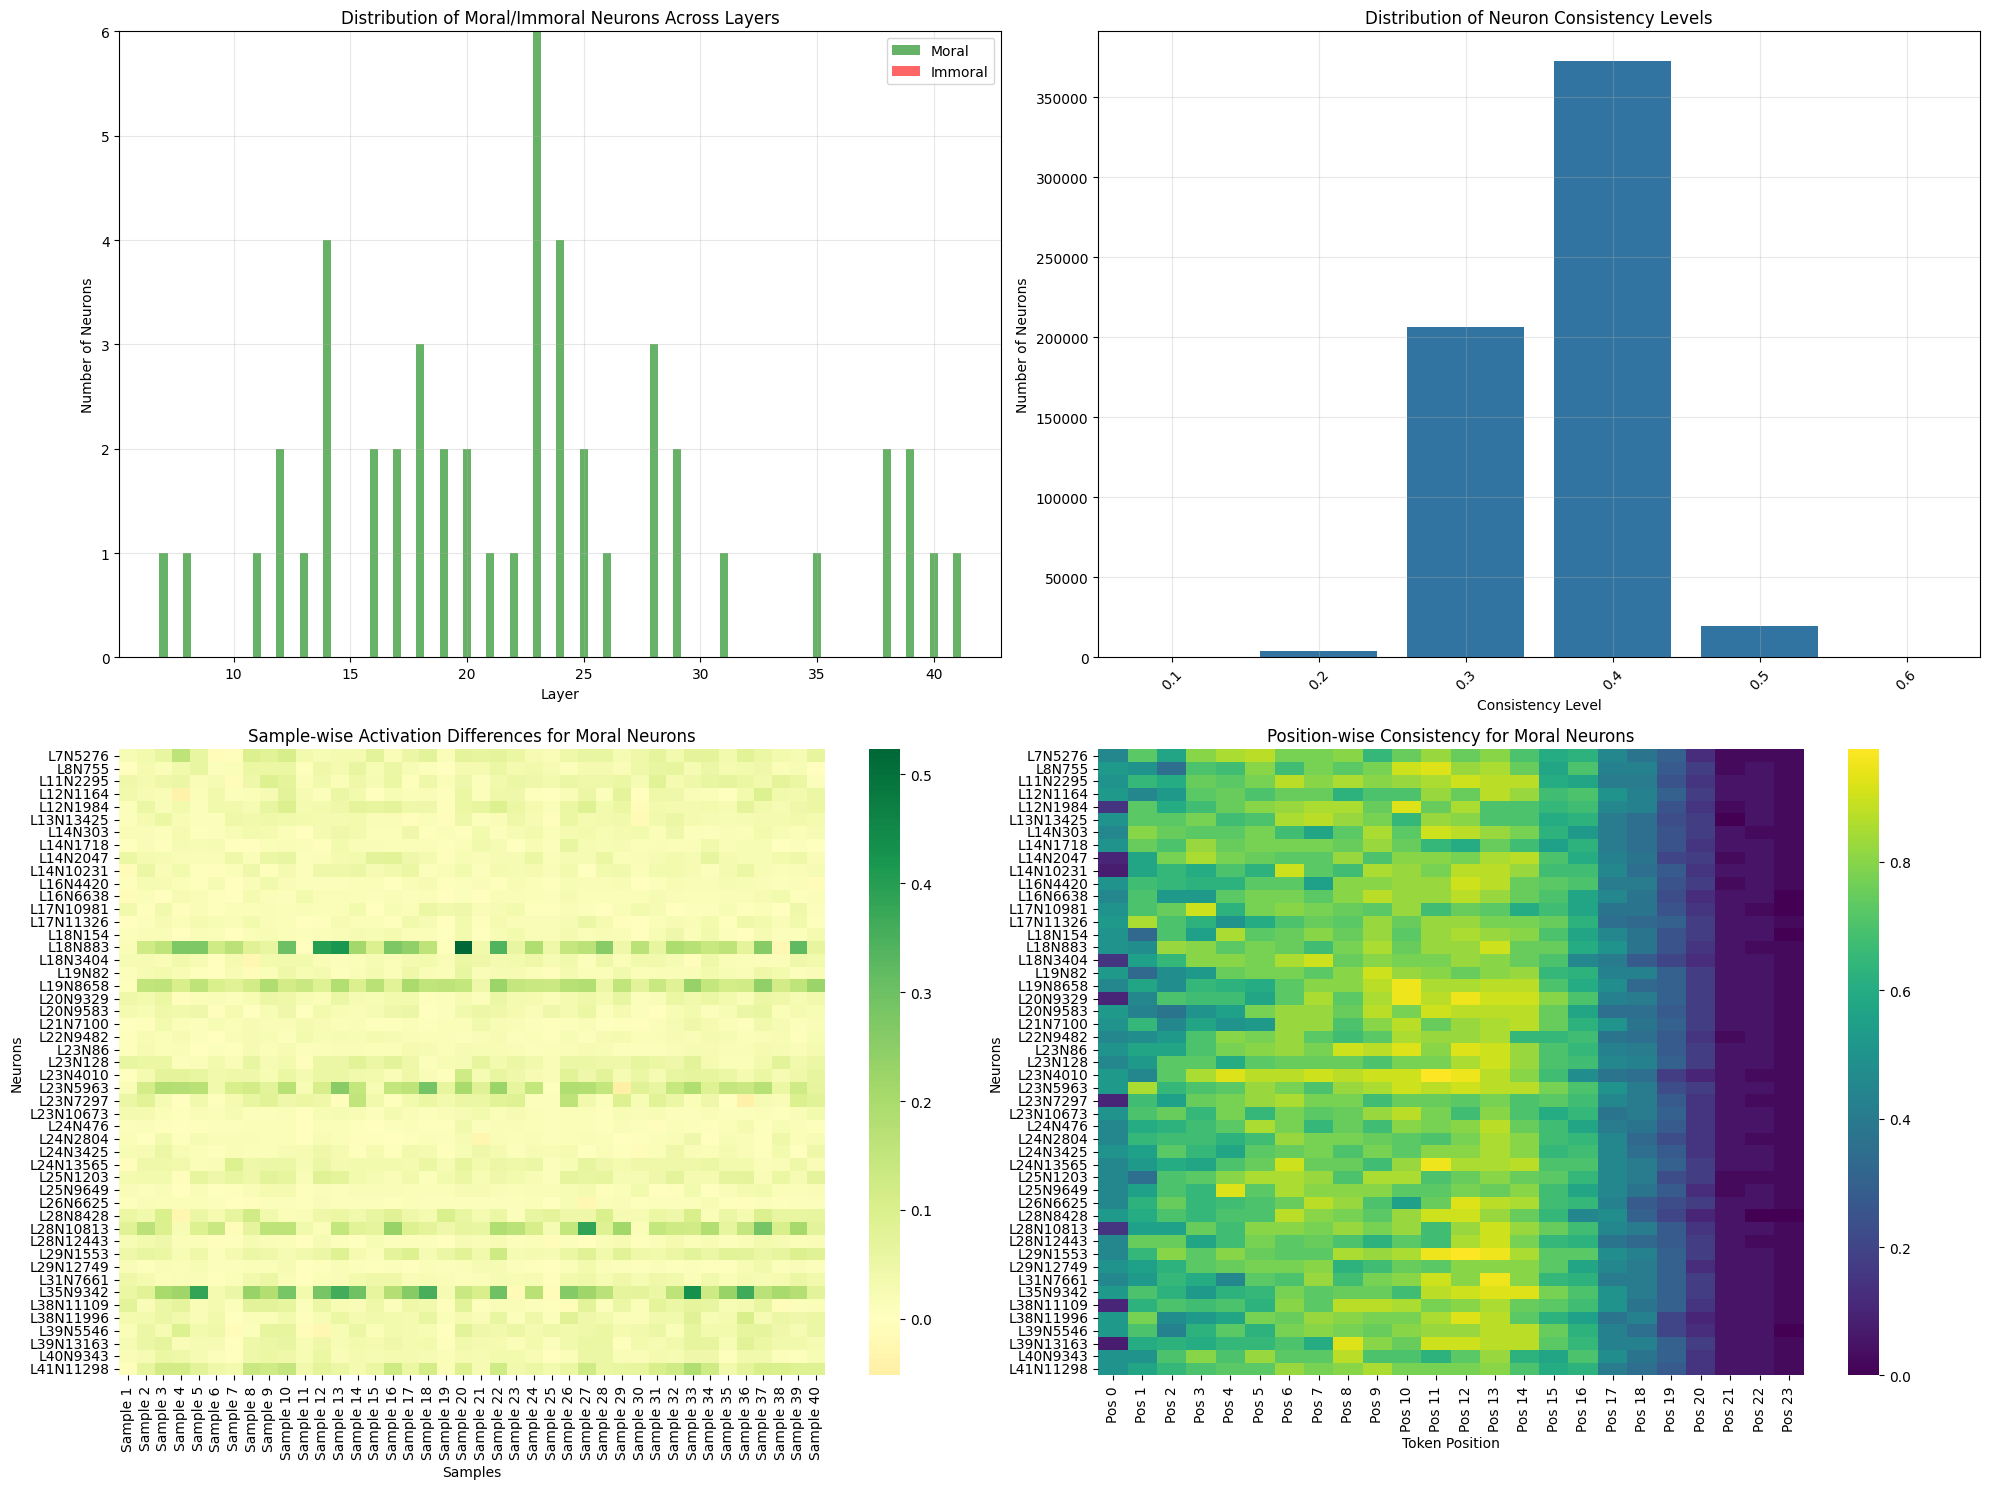

In [11]:
# Visualize the results
from src.visualization.moral_neuron_viz import plot_moral_neuron_analysis
plot_moral_neuron_analysis(results, moral_pairs, save_path="../results/moral_neuron_analysis.png", dimension="care")